<a href="https://colab.research.google.com/github/akashbhakat-bit/AMO1/blob/main/almost%20done%20R_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
install.packages("tidyverse")
install.packages("ggthemes")
install.packages("lubridate")
install.packages("skimr")
install.packages("janitor")
install.packages("httr")
install.packages("readxl")
install.packages("vroom")
install.packages("countrycode")
install.packages("patchwork")
install.packages("gganimate")
install.packages("tictoc")
install.packages("DBI")
install.packages("dbplyr")
install.packages("arrow")
install.packages("rvest")
install.packages("scales")
install.packages("readxl")
install.packages("plotly")
install.packages("mosaic")
install.packages("infer")
install.packages("here")
install.packages("wbstats")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Inst

In [45]:
# importing libraries

library(tidyverse)
library(mosaic)
library(ggthemes)
library(lubridate)
library(here)
library(skimr)
library(janitor)
library(httr)
library(readxl)
library(vroom)
library(wbstats)
library(countrycode)
library(patchwork)
library(gganimate)
library(tictoc)
library(DBI)
library(dbplyr)
library(arrow)
library(rvest)
library(scales)
library(readxl)
library(plotly)
library(infer)

# Exploring sources of electricity production, CO2 emissions, and GDP per capita.

## 1. A stacked area chart that shows how your own country generated its electricity since 2000.

You will use

`geom_area(colour="grey90", alpha = 0.5, position = "fill")`

## 2. A scatter plot that looks at how CO2 per capita and GDP per capita are related

## 3. A scatter plot that looks at how electricity usage (kWh) per capita/day GDP per capita are related

Specific questions:

1.  How would you turn `energy` to long, tidy format?
2.  You may need to join these data frames
    -   Use `left_join` from `dplyr` to [join the tables](http://r4ds.had.co.nz/relational-data.html)
    -   To complete the merge, you need a unique *key* to match observations between the data frames. Country names may not be consistent among the three dataframes, so please use the 3-digit ISO code for each country
    -   An aside: There is a great package called [`countrycode`](https://github.com/vincentarelbundock/countrycode) that helps solve the problem of inconsistent country names (Is it UK? United Kingdom? Great Britain?). `countrycode()` takes as an input a country's name in a specific format and outputs it using whatever format you specify.
3.  Write a function that takes as input any country's name and returns all three graphs. You can use the `patchwork` package to arrange the three graphs as shown below


In [150]:
# Download electricity data
url <- "https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv"

energy <- read_csv(url) %>%
  filter(year >= 1990) %>%
  drop_na(iso_code) %>%
  select(1:3,
         biofuel = biofuel_electricity,
         coal = coal_electricity,
         gas = gas_electricity,
         hydro = hydro_electricity,
         nuclear = nuclear_electricity,
         oil = oil_electricity,
         other_renewable = other_renewable_exc_biofuel_electricity,
         solar = solar_electricity,
         wind = wind_electricity,
         electricity_demand,
         electricity_generation,
         net_elec_imports,    # Net electricity imports, measured in terawatt-hours
         energy_per_capita,    # Primary energy consumption per capita, measured in kilowatt-hours    Calculated by Our World in Data based on BP Statistical Review of World Energy and EIA International Energy Data
         energy_per_gdp,    # Energy consumption per unit of GDP. This is measured in kilowatt-hours per 2011 international-$.
         per_capita_electricity, #    Electricity generation per capita, measured in kilowatt-hours
  )

# Download data for C02 emissions per capita https://data.worldbank.org/indicator/EN.ATM.CO2E.PC
co2_percap <- wb_data(country = "countries_only",
                      indicator = "EN.ATM.CO2E.PC",
                      start_date = 1990,
                      end_date = 2022,
                      return_wide=FALSE) %>%
  filter(!is.na(value)) %>%
  #drop unwanted variables
  select(-c(unit, obs_status, footnote, last_updated)) %>%
  rename(year = date,
         co2percap = value)


# Download data for GDP per capita  https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD
gdp_percap <- wb_data(country = "countries_only",
                      indicator = "NY.GDP.PCAP.PP.KD",
                      start_date = 1990,
                      end_date = 2022,
                      return_wide=FALSE) %>%
  filter(!is.na(value)) %>%
  #drop unwanted variables
  select(-c(unit, obs_status, footnote, last_updated)) %>%
  rename(year = date,
         GDPpercap = value)

Rows: 22012 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): country, iso_code
dbl (127): year, population, gdp, biofuel_cons_change_pct, biofuel_cons_chan...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 1. A stacked area chart that shows how your own country generated its electricity since 2000.

You will use

`geom_area(colour="grey90", alpha = 0.5, position = "fill")`

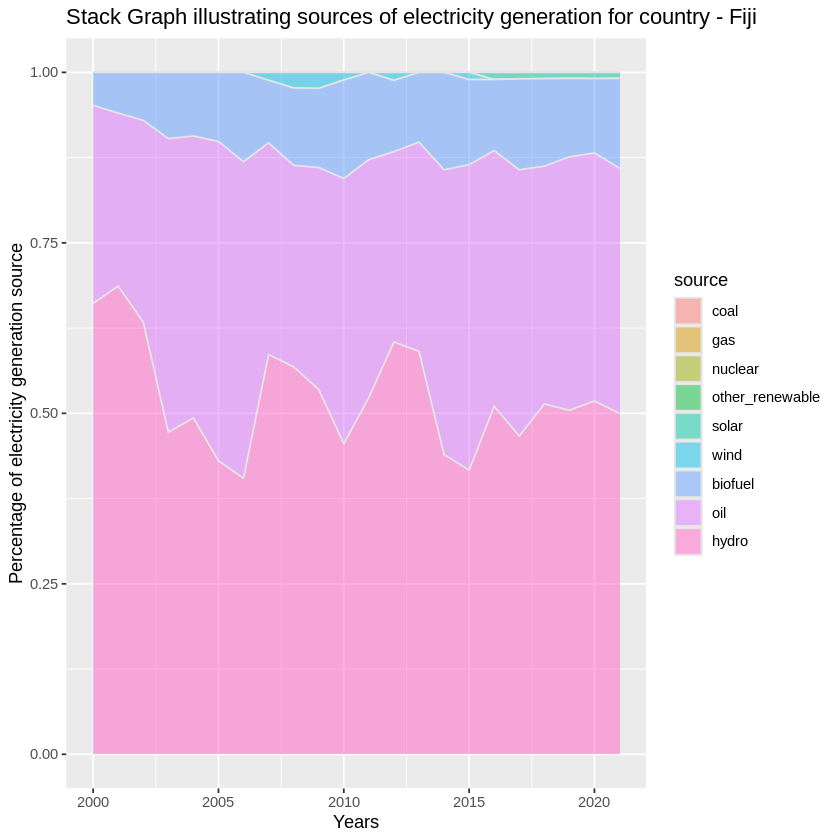

In [157]:
# Creating function - generate_stack_graph to get visualization of sources of electricity generation for given country
generate_stack_graph <- function(country_name){
energy %>%
  filter(country == country_name, year>1999) %>%                                                    # filtering based on country and years 2000 onwards
  pivot_longer(                                                                 # to get different sources like coal, gas under 1 column - sources
    cols = c(biofuel, coal, gas, hydro, nuclear, oil, other_renewable, solar, wind),
    names_to = "source",
    values_to = "megawatt"                                                      # values to Megawatt
  ) %>% mutate(source = fct_reorder(source, megawatt)) %>%                      # arranging sources in descending order
    select (country, year, source,megawatt) %>%                                 # selecting columns of interest
    ggplot(aes(x=year,y=megawatt,fill=source))+                                 # plotting stack area plot
    geom_area(colour="grey90", alpha = 0.5, position = "fill") +
    labs(x="Years",y="Percentage of electricity generation source",             # adding labels
    title = paste("Stack Graph illustrating sources of electricity generation for country -", country_name) )

}

generate_stack_graph("Fiji")                                                    # For country Fiji

2. A scatter plot that looks at how CO2 per capita and GDP per capita are related

In [ ]:
# modifying co2_percap dataframe to get columns of interest
modified_co2 <- co2_percap %>% group_by(iso3c) %>% select(year, iso3c, co2percap)

head(modified_co2) # glimse into data


In [ ]:
# modifying gdp_percap dataframe to get columns of interest
modified_gdp <- gdp_percap %>% group_by(iso3c) %>% select(year, iso3c, GDPpercap)

head(modified_gdp) # glimse into data

# We notice there are some countries and years not mutually present.
# cleaning the dataframes before left-joining

# nations not mutually present
nations_in_co2 <- unique(modified_co2$iso3c)
nations_in_gdp <- unique(modified_gdp$iso3c)

# getting nations not present mutually
values_not_in_co2 <- nations_in_gdp[!(nations_in_gdp %in% nations_in_co2)]
values_not_in_gdp <- nations_in_co2[!(nations_in_co2 %in% nations_in_gdp)]

values_not_in_co2
values_not_in_gdp


In [161]:
# modifing dataframes by removing nations not mutually present
modified_gdp <- modified_gdp %>% filter(!(iso3c %in% c('ABW','BMU','CYM','CUW','HKG','XKX','MAC','PRI','SMR','SXM','TCA','PSE')))
modified_co2 <- modified_co2 %>% filter(!(iso3c %in% c('AND','CUB','ERI','PRK','LIE','SSD','SYR','VEN','YEM')))

In [171]:
# left joining co2 and gdp dataframes
joined_co2_gdp <- left_join(modified_co2, modified_gdp, by = c("iso3c","year"))
joined_co2_gdp <- na.omit(joined_co2_gdp) # Removing na values
head(joined_co2_gdp) # glimse into the data

year,iso3c,co2percap,GDPpercap
<dbl>,<chr>,<dbl>,<dbl>
2020,AFG,0.2234789,1968.341
2019,AFG,0.2975637,2079.922
2018,AFG,0.2990826,2060.699
2017,AFG,0.2811958,2096.093
2016,AFG,0.2683588,2101.422
2015,AFG,0.2979718,2108.714


Country wise distribution

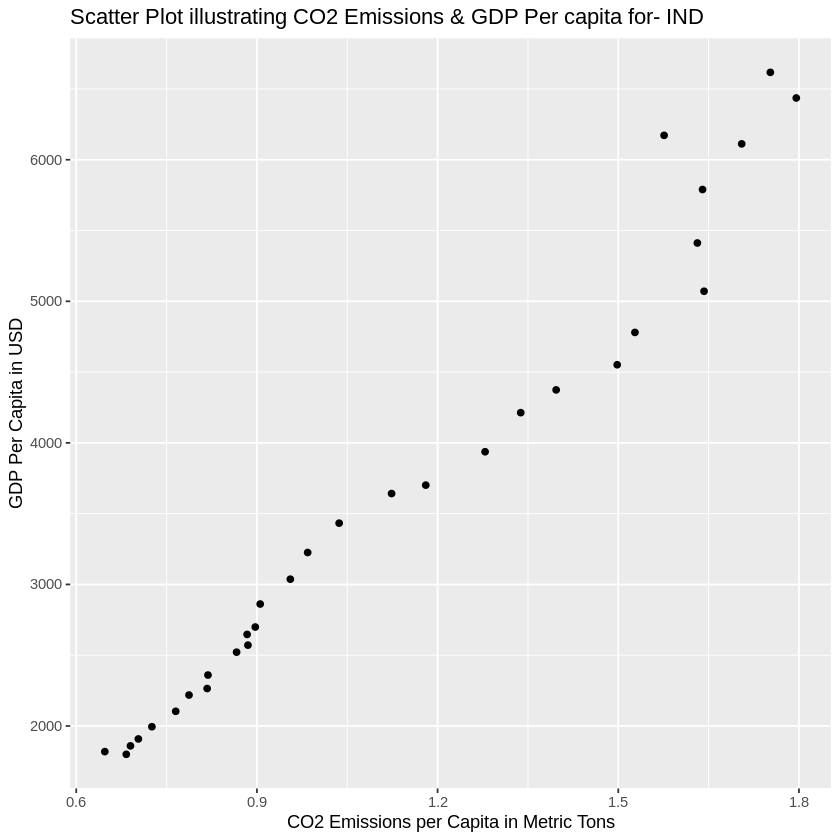

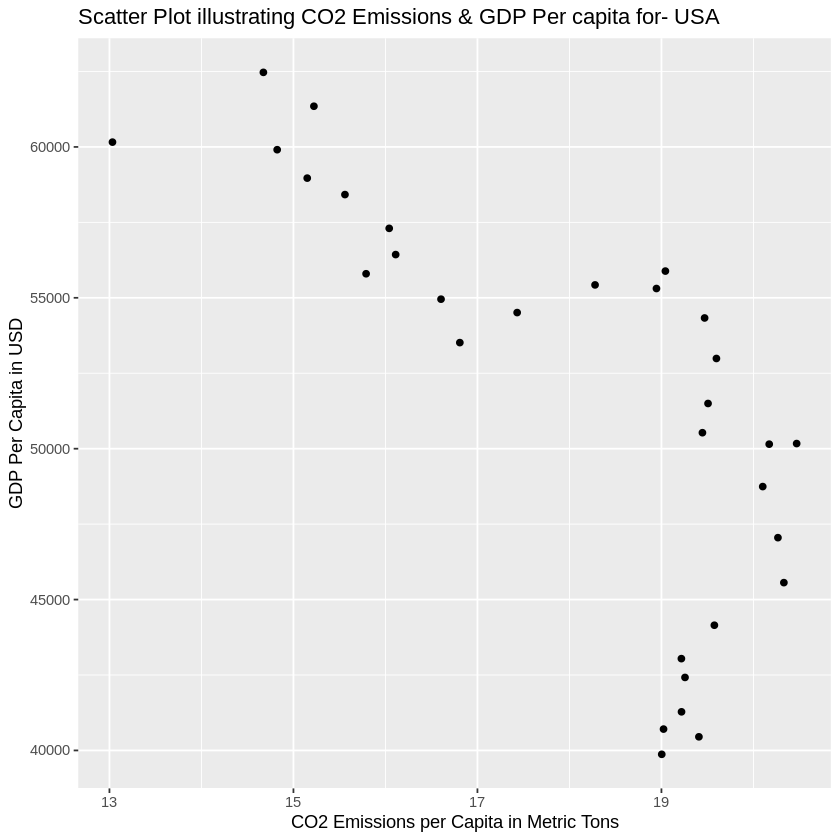

In [196]:
## For country wise illustrations

scatter_plot_co2_gpd_percapita_country <- function(country_iso3c){              # Function to get scatter plot for co2 emission and gdp per capita for given country
joined_co2_gdp %>%
  filter(iso3c == country_iso3c) %>%                                            # filtering to get specified country data
  group_by(year) %>%                                                            # grouping by year
  arrange(year) %>%                                                             # arranging by ascending order of year to get data aligned from oldest to newest
  ggplot(aes(x=co2percap,y=GDPpercap))+                                         # plotting scatter plot
  geom_point() +
  labs(                                                                         # adding labels
    title = paste("Scatter Plot illustrating CO2 Emissions & GDP Per capita for-", country_iso3c),
    y = "GDP Per Capita in USD",
    x = "CO2 Emissions per Capita in Metric Tons"
  )

}
scatter_plot_co2_gpd_percapita_country("IND")                                   # for India
scatter_plot_co2_gpd_percapita_country("USA")                                   # for USA

Global Distribution

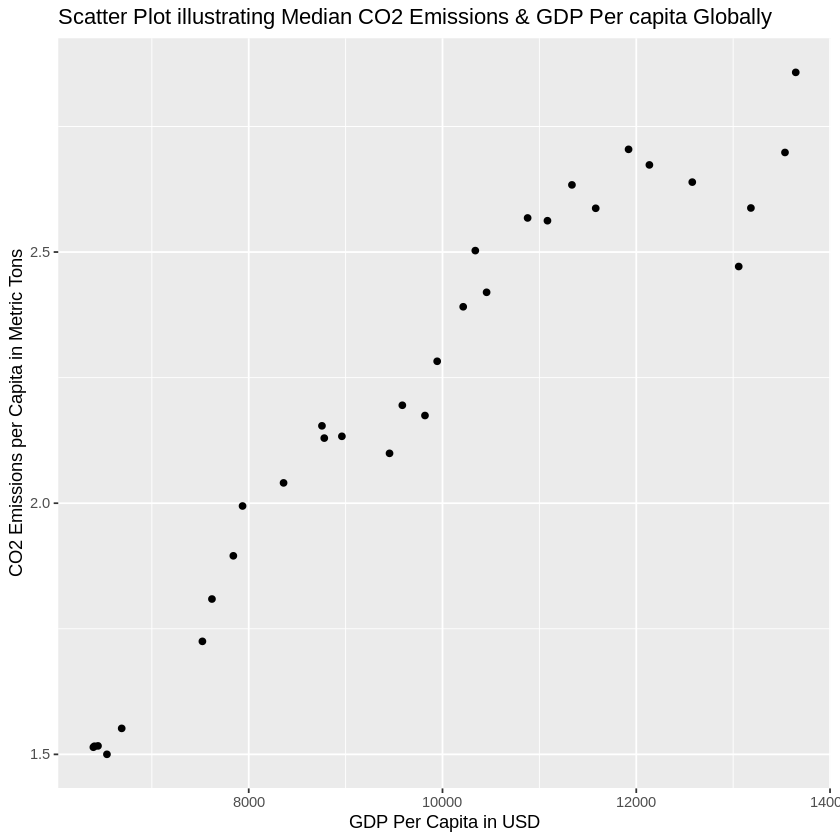

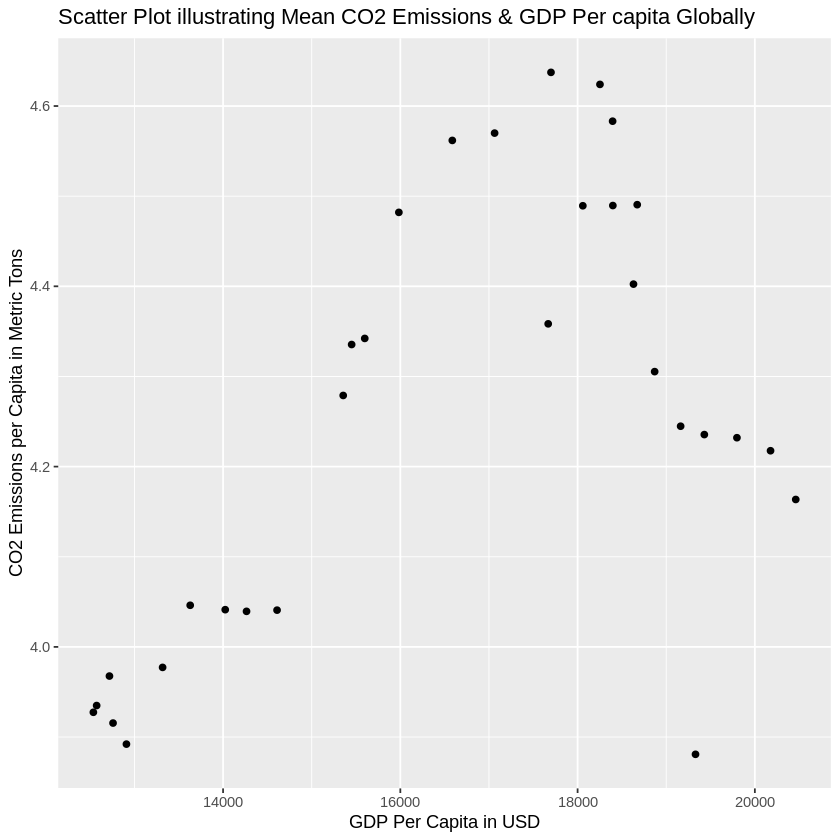

In [198]:
## Approach - Calculate co2 and gdp data by 1. Mean
##                                          2. Median
## Reason - for early dates, the data points in mean is weighted towards developed and higher developing nations.
##        - to remove such weightage, median can act as better central measure.

# plotting scatter plot - median wise

global_co2_gdp_median <- joined_co2_gdp %>%
  group_by(year) %>%
  summarize(median_co2 = median(co2percap),
            median_gdp = median(GDPpercap))

# plotting for global illustrations based on median measure
ggplot(global_co2_gdp_median, aes(y=median_co2,x=median_gdp))+
  geom_point() +
  labs(
    title = "Scatter Plot illustrating Median CO2 Emissions & GDP Per capita Globally",
    x = "GDP Per Capita in USD",
    y = "CO2 Emissions per Capita in Metric Tons"
  )

# plotting scatter plot - mean wise

global_co2_gdp_mean <- joined_co2_gdp %>%
  group_by(year) %>%
  summarize(mean_co2 = mean(co2percap),
            mean_gdp = mean(GDPpercap))

# plotting for global illustrations based on median measure
ggplot(global_co2_gdp_mean, aes(y=mean_co2,x=mean_gdp))+
  geom_point() +
  labs(
    title = "Scatter Plot illustrating Mean CO2 Emissions & GDP Per capita Globally",
    x = "GDP Per Capita in USD",
    y = "CO2 Emissions per Capita in Metric Tons"
  )

3. A scatter plot that looks at how electricity usage (kWh) per capita/day GDP per capita are related

In [199]:
# creating a new dataframe with columns of interest
modified_energy <- energy %>%
  select(year, iso_code,energy_per_capita)

modified_gdp_percap2 <- gdp_percap %>%
  select(year, iso3c, GDPpercap)

# Joining 2 dataframes


In [ ]:
## Approach - Calculate electricity usage and gdp data by 1. Mean of all nations
##                                                        2. Median of all nations
## Reason - for early dates, the data points in mean is weighted towards developed and higher developing nations.
##        - to remove such weightage, median can act as better central measure.

# plotting scatter plot - median wise

global_energy_gdp_median <- joined_co2_gdp %>%
  group_by(year) %>%
  summarize(median_co2 = median(co2percap),
            median_gdp = median(GDPpercap))

# plotting for global illustrations based on median measure
ggplot(global_co2_gdp_median, aes(y=median_co2,x=median_gdp))+
  geom_point() +
  labs(
    title = "Scatter Plot illustrating Median CO2 Emissions & GDP Per capita Globally",
    x = "GDP Per Capita in USD",
    y = "CO2 Emissions per Capita in Metric Tons"
  )

# plotting scatter plot - mean wise

global_co2_gdp_mean <- joined_co2_gdp %>%
  group_by(year) %>%
  summarize(mean_co2 = mean(co2percap),
            mean_gdp = mean(GDPpercap))

# plotting for global illustrations based on median measure
ggplot(global_co2_gdp_mean, aes(y=mean_co2,x=mean_gdp))+
  geom_point() +
  labs(
    title = "Scatter Plot illustrating Mean CO2 Emissions & GDP Per capita Globally",
    x = "GDP Per Capita in USD",
    y = "CO2 Emissions per Capita in Metric Tons"
  )

In [189]:
head(gdp_percap)

indicator_id,indicator,iso2c,iso3c,country,year,GDPpercap
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2021,1517.016
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2020,1968.341
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2019,2079.922
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2018,2060.699
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2017,2096.093
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 international $)",AF,AFG,Afghanistan,2016,2101.422
